# Reconstructing the Southeast Asian NWFZ

Article 2 of [The Treaty of Bangkok](https://treaties.unoda.org/t/bangkok) says:

> This Treaty and its Protocol shall apply to the territories, continental shelves, and EEZ of the States Parties within the Zone in which this Treaty is in force.

The continental shelf here is [a legal contstruct](https://en.wikipedia.org/wiki/Convention_on_the_Continental_Shelf), not a physical one, and generally extends 200NM from the coast. Some countries claim extended continental shelves beyond that limit, but they're not mentioned in the treaty, somewhat contested, and not present [on this UNODA map](https://disarmament.unoda.org/wmd/nuclear/nwfz/) so we'll ignore them for now.


In [2]:
import pandas as pd
import geopandas as gp
import shapely as shp
import sys

sys.path.append('..')
import utils.close_holes

world_admin0_raw = gp.read_file("./tmp/ne_50m_admin_0_countries/ne_50m_admin_0_countries.shp")
world_eez_raw = gp.read_file("./tmp/World_EEZ_v12_20231025/eez_v12.shp")
treaty_members = pd.read_csv("./data/bangkok_members.csv")

<Axes: >

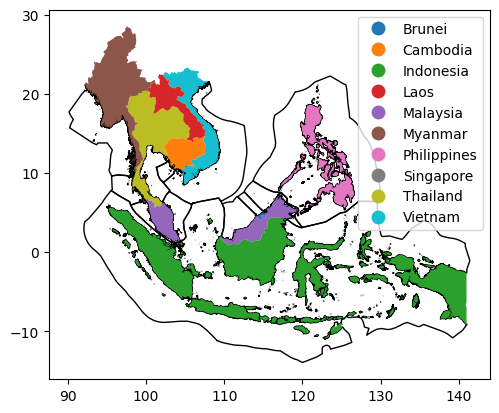

In [5]:
world_admin0 = world_admin0_raw.set_crs(epsg=4326)
world_eez = world_eez_raw.set_crs(epsg=4326)

treaty_eez = world_eez.loc[
    (world_eez["ISO_SOV1"].isin(list(treaty_members["code"]))) &
    (world_eez["POL_TYPE"] == "200NM")
    ].reset_index()

treaty_land = world_admin0.loc[
    (world_admin0["SOV_A3"].isin(list(treaty_members["code"])))
    ].reset_index()

ax = treaty_eez.plot(color="none", edgecolor="black")
treaty_land.plot(ax=ax,column="ADMIN", legend=True)

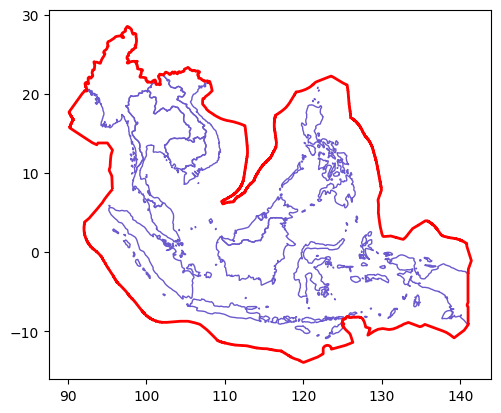

In [6]:
# Build treaty extent geometry 
treaty_geo = shp.union_all(
    [*list(treaty_eez.geometry), *list(treaty_land.geometry)],
    grid_size=.01)

treaty_extent = gp.GeoDataFrame(
    data={"geometry": [treaty_geo]},
    geometry="geometry",
    crs="EPSG:4326",
)

treaty_extent.geometry = treaty_extent.geometry.apply(lambda x: utils.close_holes.close_holes(x))

ax = treaty_land.plot(color="none", edgecolor="slateblue")
treaty_extent.plot(ax=ax, color="none", edgecolor="red", lw=2)

treaty_extent.to_file("./tmp/bangkok-extent.geojson")